<a href="https://colab.research.google.com/github/bullet400/San_Francisco_Crime_Classification/blob/master/chicago_crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
                                                                                                                                                                                                                                                                                                                                                                    from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [3]:
%matplotlib inline

In [4]:

chicago_crime  =pd.read_csv('/content/drive/MyDrive/Chicago_Crimes_2012.csv', error_bad_lines =False)

In [5]:
chicago_crime.shape

(1456714, 23)

In [6]:
chicago_crime.head(2)

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"


In [7]:
chicago_crime.describe()

,Unnamed: 0,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,1.456714e+06,1.456714e+06,1.456714e+06,1.456713e+06,1.456700e+06,1.456674e+06,1.419631e+06,1.419631e+06,1.456714e+06,1.419631e+06,1.419631e+06
mean,3.308606e+06,9.597550e+06,1.150644e+03,1.125920e+01,2.287027e+01,3.745632e+01,1.164398e+06,1.885523e+06,2.013897e+03,4.184147e+01,-8.767224e+01
std,1.235350e+06,8.083505e+05,6.916466e+02,6.904691e+00,1.380589e+01,2.144029e+01,1.850835e+04,3.424775e+04,1.449584e+00,9.430126e-02,6.661726e-02
min,3.000000e+00,2.022400e+04,1.110000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.012000e+03,3.661945e+01,-9.168657e+01
25%,2.698636e+06,9.002709e+06,6.130000e+02,6.000000e+00,1.000000e+01,2.300000e+01,1.152544e+06,1.858762e+06,2.013000e+03,4.176787e+01,-8.771528e+01
50%,3.063654e+06,9.605776e+06,1.024000e+03,1.000000e+01,2.300000e+01,3.200000e+01,1.166021e+06,1.891502e+06,2.014000e+03,4.185797e+01,-8.766613e+01
75%,3.428849e+06,1.022577e+07,1.711000e+03,1.700000e+01,3.400000e+01,5.600000e+01,1.176363e+06,1.908713e+06,2.015000e+03,4.190529e+01,-8.762813e+01
max,6.253474e+06,1.082788e+07,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,1.205119e+06,1.951573e+06,2.017000e+03,4.202271e+01,-8.752453e+01


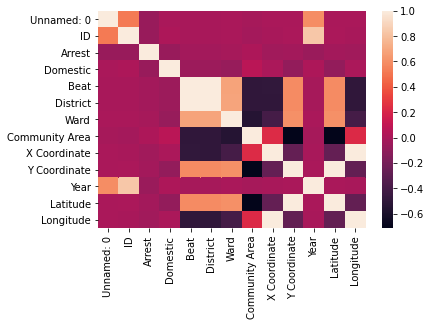

In [8]:
sns.heatmap(chicago_crime.corr())

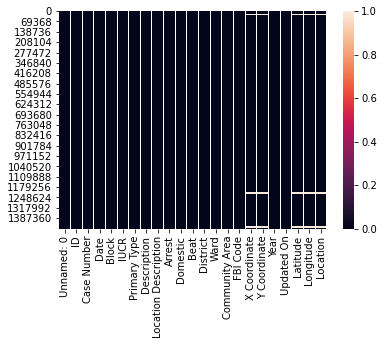

In [9]:
sns.heatmap(chicago_crime.isnull())

In [10]:
chicago_crime.dropna(inplace=True)

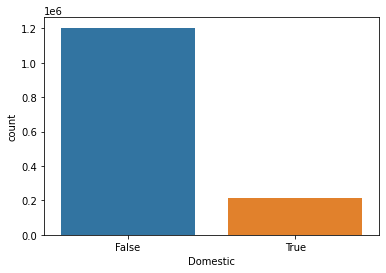

In [11]:
sns.countplot(x='Domestic', data=chicago_crime)

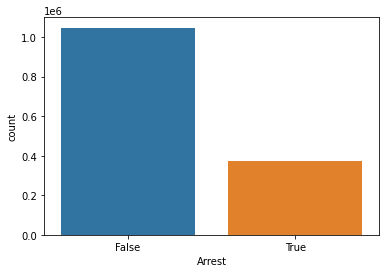

In [12]:
sns.countplot(x='Arrest', data=chicago_crime)

In [13]:
chicago_crime['Location Description'].nunique(dropna=True)

140

In [14]:
df=chicago_crime.drop(['Unnamed: 0','ID','FBI Code','IUCR','X Coordinate','Y Coordinate','Updated On','Case Number','District','Latitude','Longitude','Beat',
                      'Community Area','Ward','Year','Location'],axis=1)

In [15]:
df.tail(10)

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
1456704,05/03/2016 11:30:00 PM,053XX S PULASKI RD,ROBBERY,STRONGARM - NO WEAPON,SIDEWALK,False,False
1456705,05/03/2016 11:50:00 PM,036XX E 106TH ST,OTHER OFFENSE,FALSE/STOLEN/ALTERED TRP,ALLEY,True,False
1456706,05/03/2016 10:25:00 PM,071XX S MOZART ST,BATTERY,SIMPLE,SIDEWALK,True,False
1456707,05/03/2016 11:00:00 PM,085XX S MAY ST,ROBBERY,STRONGARM - NO WEAPON,SIDEWALK,False,False
1456708,05/03/2016 11:28:00 PM,088XX S LAFLIN ST,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False
1456709,05/03/2016 11:33:00 PM,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
1456710,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
1456711,05/03/2016 12:15:00 AM,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False
1456712,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True
1456713,05/03/2016 11:38:00 PM,001XX E 75TH ST,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,False


## conversion of the date into a datetime format

In [16]:
df.Date =pd.to_datetime(df.Date, format ='%m/%d/%Y %I:%M:%S %p')

In [17]:
df.index =pd.DatetimeIndex(df.Date)

In [18]:
df['Date'].unique()

array(['2016-05-03T23:40:00.000000000', '2016-05-03T21:40:00.000000000',
       '2016-05-03T23:31:00.000000000', ...,
       '2016-05-03T23:28:00.000000000', '2016-05-03T23:33:00.000000000',
       '2016-05-03T21:07:00.000000000'], dtype='datetime64[ns]')

In [19]:
df.head()

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,
2016-05-03 23:40:00,2016-05-03 23:40:00,013XX S SAWYER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
2016-05-03 21:40:00,2016-05-03 21:40:00,061XX S DREXEL AVE,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True
2016-05-03 23:31:00,2016-05-03 23:31:00,053XX W CHICAGO AVE,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False
2016-05-03 22:10:00,2016-05-03 22:10:00,049XX W FULTON ST,BATTERY,SIMPLE,SIDEWALK,False,False
2016-05-03 22:00:00,2016-05-03 22:00:00,003XX N LOTUS AVE,THEFT,$500 AND UNDER,RESIDENCE,False,True


In [20]:
df['Primary Type'].value_counts()

THEFT                                321950
BATTERY                              258941
CRIMINAL DAMAGE                      152812
NARCOTICS                            131177
ASSAULT                               89508
OTHER OFFENSE                         85361
BURGLARY                              81668
DECEPTIVE PRACTICE                    67609
MOTOR VEHICLE THEFT                   59856
ROBBERY                               56092
CRIMINAL TRESPASS                     36429
WEAPONS VIOLATION                     16983
PUBLIC PEACE VIOLATION                13015
OFFENSE INVOLVING CHILDREN            10590
PROSTITUTION                           7567
CRIM SEXUAL ASSAULT                    6298
INTERFERENCE WITH PUBLIC OFFICER       6136
SEX OFFENSE                            4491
HOMICIDE                               2590
GAMBLING                               2211
ARSON                                  2175
LIQUOR LAW VIOLATION                   1928
KIDNAPPING                      

In [21]:
df['Description'].value_counts()

SIMPLE                            147845
$500 AND UNDER                    132848
DOMESTIC BATTERY SIMPLE           128283
TO VEHICLE                         74572
OVER $500                          72957
                                   ...  
EMPLOY MINOR                           1
JUVENILE PIMPING                       1
POSS. KEYS OR DEV.TO COIN MACH         1
ALTER COINS                            1
REFUSING TO AID AN OFFICER             1
Name: Description, Length: 340, dtype: int64

## finding the top 10 crimes that was comitted

In [22]:
df['Primary Type'].value_counts().iloc[:10]

THEFT                  321950
BATTERY                258941
CRIMINAL DAMAGE        152812
NARCOTICS              131177
ASSAULT                 89508
OTHER OFFENSE           85361
BURGLARY                81668
DECEPTIVE PRACTICE      67609
MOTOR VEHICLE THEFT     59856
ROBBERY                 56092
Name: Primary Type, dtype: int64

In [23]:
order_num =df['Primary Type'].value_counts().iloc[:10].index

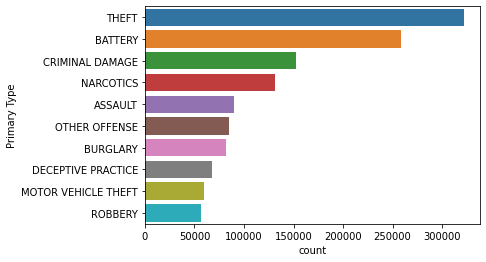

In [24]:
sns.countplot(y='Primary Type', data=df, order=order_num)

## finding how many of the crimes are street base,(location)

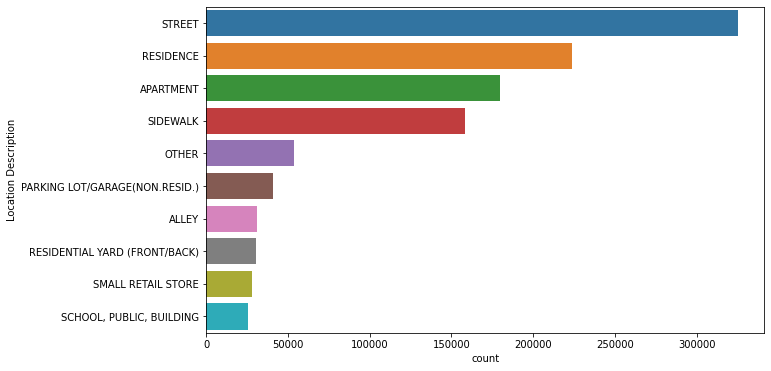

In [25]:
order_num2 =df['Location Description'].value_counts().iloc[:10].index
plt.figure(figsize=(10,6))
sns.countplot(y='Location Description', data=df, order =order_num2)

## finding the number of specific crime that occured in a specific month

In [26]:
df.resample('Y').size()

Date
2012-12-31    334397
2013-12-31    304267
2014-12-31    269329
2015-12-31    259610
2016-12-31    250732
2017-12-31        30
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of Crimes in a year')

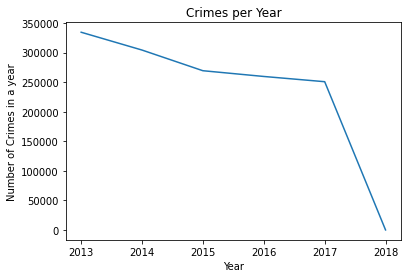

In [27]:
plt.plot(df.resample('Y').size())
plt.title('Crimes per Year')
plt.xlabel('Year')
plt.ylabel('Number of Crimes in a year')

In [28]:
df.resample('M').size()

Date
2012-01-31    26006
2012-02-29    23762
2012-03-31    28461
2012-04-30    27085
2012-05-31    29986
              ...  
2016-09-30    22402
2016-10-31    22530
2016-11-30    20428
2016-12-31    19070
2017-01-31       30
Freq: M, Length: 61, dtype: int64

Text(0, 0.5, 'Number of Crimes in a month')

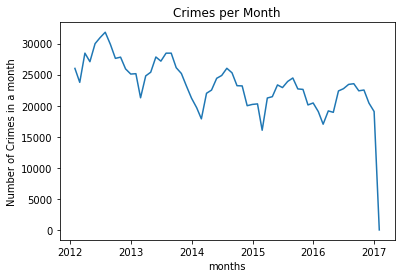

In [29]:
plt.plot(df.resample('M').size())
plt.title('Crimes per Month')
plt.xlabel('months')
plt.ylabel('Number of Crimes in a month')

Text(0, 0.5, 'Number of Crimes in a day')

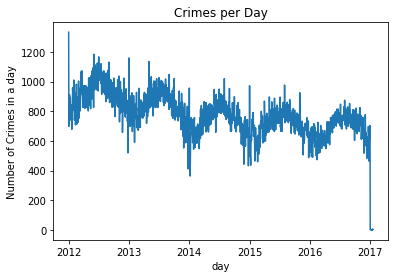

In [30]:
plt.plot(df.resample('d').size())
plt.title('Crimes per Day')
plt.xlabel('day')
plt.ylabel('Number of Crimes in a day')

Text(0, 0.5, 'Number of Crimes in a Quater')

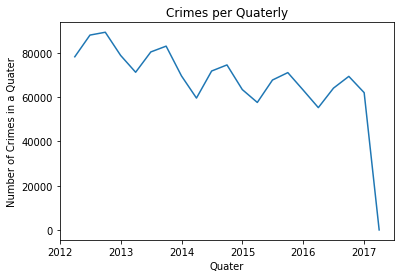

In [31]:
plt.plot(df.resample('Q').size())
plt.title('Crimes per Quaterly')
plt.xlabel('Quater')
plt.ylabel('Number of Crimes in a Quater')

In [32]:
df_1 =df.resample('M').size().reset_index()

In [33]:
df_1

,Date,0
0,2012-01-31,26006
1,2012-02-29,23762
2,2012-03-31,28461
3,2012-04-30,27085
4,2012-05-31,29986
...,...,...
56,2016-09-30,22402
57,2016-10-31,22530
58,2016-11-30,20428
59,2016-12-31,19070


In [34]:
df_1.columns =['Date','Total Crimes']

In [35]:
df_1

,Date,Total Crimes
0,2012-01-31,26006
1,2012-02-29,23762
2,2012-03-31,28461
3,2012-04-30,27085
4,2012-05-31,29986
...,...,...
56,2016-09-30,22402
57,2016-10-31,22530
58,2016-11-30,20428
59,2016-12-31,19070


In [36]:
df_2 =df_1.rename(columns ={'Date':'ds','Total Crimes':'y' })

In [37]:
df_2[['ds','y']]

,ds,y
0,2012-01-31,26006
1,2012-02-29,23762
2,2012-03-31,28461
3,2012-04-30,27085
4,2012-05-31,29986
...,...,...
56,2016-09-30,22402
57,2016-10-31,22530
58,2016-11-30,20428
59,2016-12-31,19070


In [38]:
df_2.head()

,ds,y
0,2012-01-31,26006
1,2012-02-29,23762
2,2012-03-31,28461
3,2012-04-30,27085
4,2012-05-31,29986


In [39]:
 m = Prophet()

In [40]:
m.fit(df_2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
future =m.make_future_dataframe(periods =1460)

In [42]:
forcast =m.predict(future)

In [43]:
forcast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-31,29541.744328,24545.546597,29188.653152,29541.744328,29541.744328,-2712.255011,-2712.255011,-2712.255011,-2712.255011,-2712.255011,-2712.255011,0.0,0.0,0.0,26829.489317
1,2012-02-29,29381.818426,22091.828319,27046.697641,29381.818426,29381.818426,-4615.270197,-4615.270197,-4615.270197,-4615.270197,-4615.270197,-4615.270197,0.0,0.0,0.0,24766.548229
2,2012-03-31,29210.863151,25470.443177,29872.000658,29210.863151,29210.863151,-1504.376430,-1504.376430,-1504.376430,-1504.376430,-1504.376430,-1504.376430,0.0,0.0,0.0,27706.486722
3,2012-04-30,29045.422563,24386.480895,29131.863565,29045.422563,29045.422563,-2216.438144,-2216.438144,-2216.438144,-2216.438144,-2216.438144,-2216.438144,0.0,0.0,0.0,26828.984419
4,2012-05-31,28874.467288,26984.412268,31956.321036,28874.467288,28874.467288,695.862086,695.862086,695.862086,695.862086,695.862086,695.862086,0.0,0.0,0.0,29570.329375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,2021-01-26,11440.455389,42366.934095,47101.626978,11440.113853,11440.785444,33268.620351,33268.620351,33268.620351,33268.620351,33268.620351,33268.620351,0.0,0.0,0.0,44709.075740
1517,2021-01-27,11434.942038,34588.088215,39321.989267,11434.600054,11435.272742,25532.745753,25532.745753,25532.745753,25532.745753,25532.745753,25532.745753,0.0,0.0,0.0,36967.687791
1518,2021-01-28,11429.428687,26199.780952,30884.699839,11429.086281,11429.760039,17247.029939,17247.029939,17247.029939,17247.029939,17247.029939,17247.029939,0.0,0.0,0.0,28676.458626
1519,2021-01-29,11423.915335,17632.318098,22338.428285,11423.572516,11424.247336,8542.563405,8542.563405,8542.563405,8542.563405,8542.563405,8542.563405,0.0,0.0,0.0,19966.478740


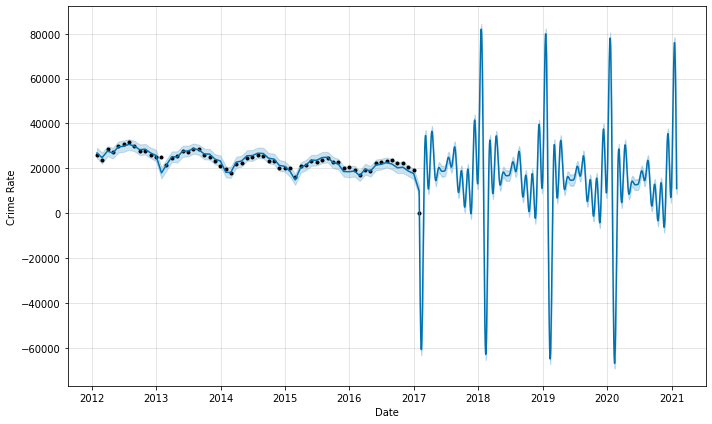

In [44]:
figure=m.plot(forcast, xlabel='Date', ylabel='Crime Rate')

## Performing the cross validation on the model

In [45]:
from fbprophet.diagnostics import cross_validation

In [46]:
df_cv = cross_validation(m, initial='35 days', period='180 days', horizon = '1460 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2012-08-05 00:00:00 and 2013-02-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


In [47]:
from fbprophet.diagnostics import performance_metrics

In [48]:
df_p =performance_metrics(df_cv)

In [49]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,148 days,5.993385e+11,774169.531205,437843.771974,15.523201,3.057802,0.111111
1,149 days,1.433064e+11,378558.269563,215134.822453,8.074493,0.796360,0.111111
2,179 days,1.460558e+11,382172.495358,232546.199565,8.766171,3.057802,0.111111
3,180 days,1.452736e+11,381147.752719,224231.250207,8.463975,0.796360,0.111111
4,207 days,1.455749e+11,381542.769363,229690.036432,8.722731,2.451013,0.111111


In [50]:
from fbprophet.plot import plot_cross_validation_metric

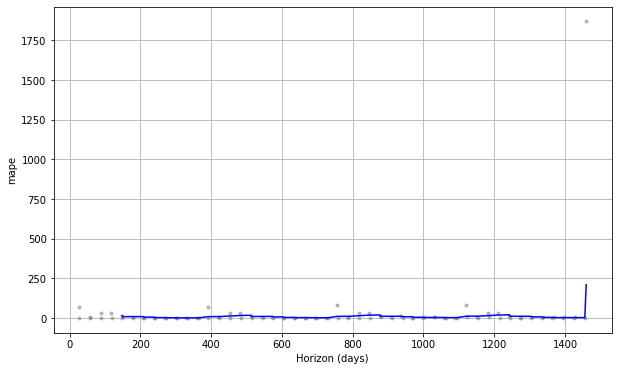

In [51]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
prediction =forcast


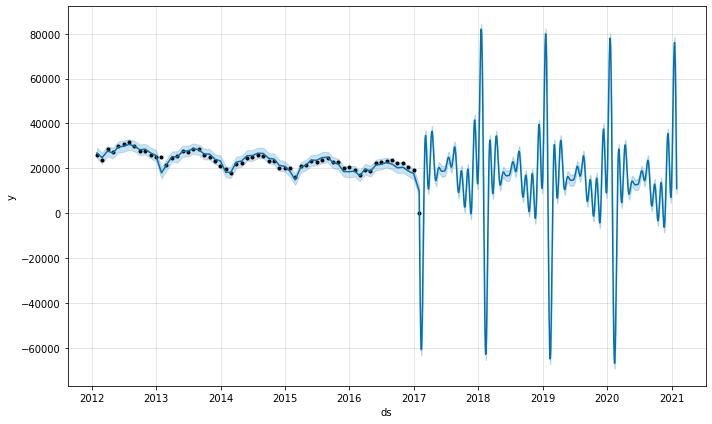

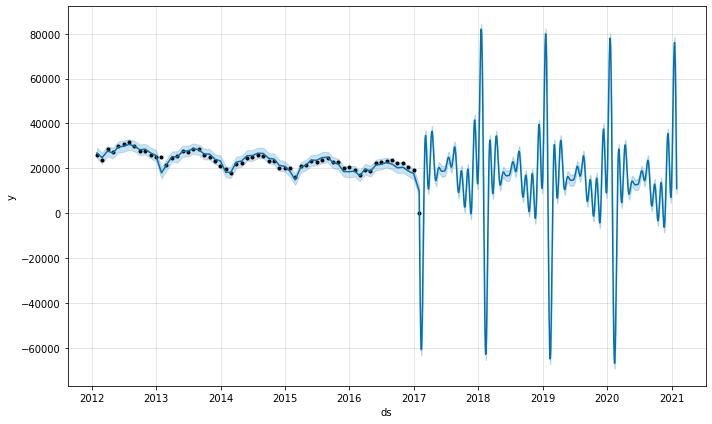

In [52]:
m.plot(prediction)

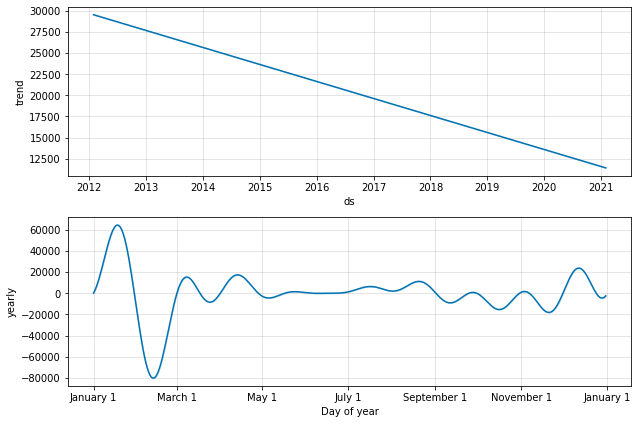

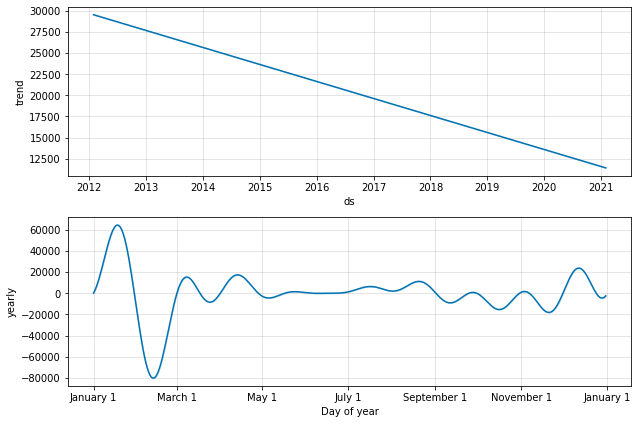

In [53]:
m.plot_components(prediction)

In [54]:
from fbprophet.plot import add_changepoints_to_plot

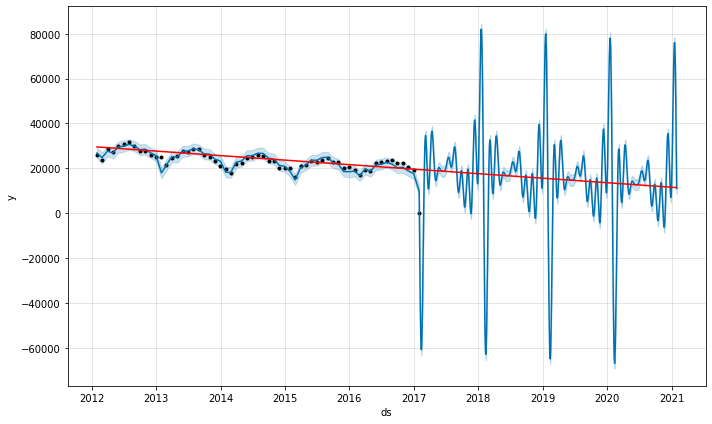

In [55]:
fig =m.plot(prediction)
c   = add_changepoints_to_plot(fig.gca(), m, prediction)

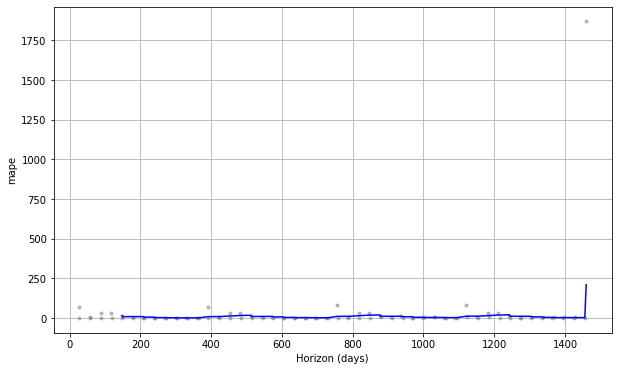

In [56]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [57]:
from dask.distributed import Client

In [58]:
client =Client()

In [59]:
df1_cv = cross_validation(m, initial='30 days', period='180 days',  horizon = '1460 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2012-08-05 00:00:00 and 2013-02-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


In [60]:
df1_cv = cross_validation(m, initial='34.5 days', period='180 days',  horizon = '1460 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2012-08-05 00:00:00 and 2013-02-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


In [61]:
df1_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-08-31,-1.996153e+06,-1.996153e+06,-1.996153e+06,29867,2012-08-05
1,2012-09-30,-5.683445e+04,-5.683445e+04,-5.683445e+04,27619,2012-08-05
2,2012-10-31,8.356161e+05,8.356161e+05,8.356161e+05,27815,2012-08-05
3,2012-11-30,7.763752e+05,7.763752e+05,7.763752e+05,25927,2012-08-05
4,2012-12-31,-2.324681e+05,-2.324681e+05,-2.324681e+05,25097,2012-08-05


In [62]:
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.

In [63]:
df3_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-02-11 00:00:00 and 2016-02-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [64]:
df3_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-02-28,17684.130392,17636.611259,17734.319447,17892,2014-02-11
1,2014-03-31,19154.785912,18973.951940,19350.988104,22005,2014-02-11
2,2014-04-30,20948.892513,20579.330318,21310.416661,22519,2014-02-11
3,2014-05-31,22619.304176,22004.247885,23190.609839,24413,2014-02-11
4,2014-06-30,20203.426601,19358.010760,21005.154249,24867,2014-02-11


The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [65]:
df_p = performance_metrics(df3_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,48 days,1.606188e+06,1267.354916,835.015969,0.042304,0.030556,0.333333
1,51 days,1.600787e+06,1265.222037,817.691292,0.041114,0.028583,0.500000
2,53 days,1.749058e+06,1322.519517,945.839531,0.047390,0.047412,0.333333
3,56 days,1.643362e+06,1281.936851,852.745159,0.040718,0.029015,0.500000
4,59 days,1.902196e+06,1379.201392,1049.415422,0.051104,0.047412,0.333333


Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out

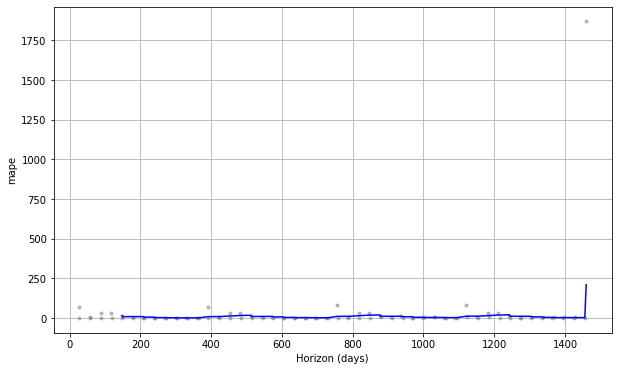

In [66]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

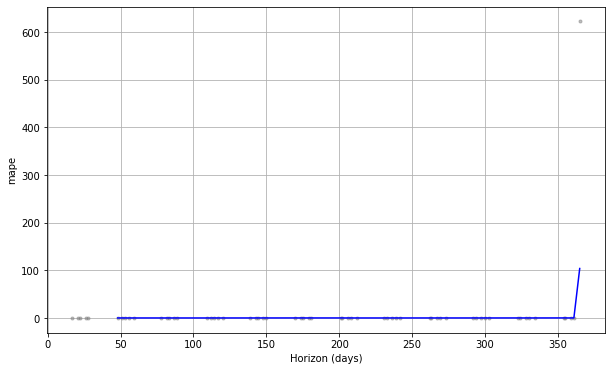

In [67]:
fig = plot_cross_validation_metric(df3_cv, metric='mape')

In [68]:
my_plot =forcast[['ds', 'yhat', 'trend']]

In [69]:
df3_cv.columns

Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'cutoff'], dtype='object')

In [70]:
df3_plot =df3_cv[['yhat','y' ]]

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [72]:
actuals = df3_cv['y']
prediction  = df3_cv['yhat']

In [73]:
print(mean_squared_error(actuals, prediction))

9426688.129525803


In [74]:
print(mean_absolute_error(actuals, prediction)) 

1623.6282090406535


In [75]:
print(np.sqrt(mean_squared_error(actuals, prediction)))

3070.291212495291
